# FRETBursts - nsALEX/PIE example
## How to use data from nsALEX/PIE to correct single-molecule FRET data and to present information regarding dynamics using MFD & BVA plots 

*This notebook is part of a [tutorial series](https://github.com/OpenSMFS/FRETBursts_notebooks) for the [FRETBursts](http://opensmfs.github.io/FRETBursts/) burst analysis software.*

> For a step-by-step introduction to FRETBursts usage please refer to 
> [us-ALEX smFRET burst analysis](FRETBursts - us-ALEX smFRET burst analysis.ipynb).
>
> In this notebook we present a typical [FRETBursts](http://opensmfs.github.io/FRETBursts/)
> workflow for **nsALEX/PIE smFRET burst analysis**. 

*While FRETBursts does not specifically includes functions for fitting 
TCSPC fluorescence decays, a fitting with exponential decays and 
IRF deconvolution can be easily performed using standard python libraries. 
For an example and a brief discussion see the notebook 
[Lifetime decay fit](http://nbviewer.ipython.org/github/tritemio/notebooks/blob/master/Lifetime_decay_fit.ipynb).*

## Loading FRETBursts

In [1]:
from fretbursts import *

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.7).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


In [2]:
sns = init_notebook()

In [3]:
filename = 'Sample Data.hdf5'
filename

'C:/Users/eitan/Documents/projects/bacterial transcription promoter spacer project/147WT_DNAonly_KG7.hdf5'

## Selecting a data file

Alternatively you can use an open-file dialog in order to select a data file:

In [5]:
import os
if os.path.isfile(filename):
    print("Perfect, I found the file!")
else:
    print("Sorry, I can't find the file:\n%s" % filename)

Perfect, I found the file!


## Load the selected file

Here we load the file and we set the alternation parameters:

In [6]:
d = loader.photon_hdf5(filename)
#d = loader.nsalex(fname)

In [7]:
d.time_max

3599.998269789619

In [8]:
d.det_t

[array([ 1,  1,  1, ..., 66,  0,  1], dtype=uint8)]

In [9]:
print("Detector    Counts")
print("--------   --------")
for det, count in zip(*np.unique(d.det_t, return_counts=True)):
    print("%8d   %8d" % (det, count))

Detector    Counts
--------   --------
       0   10902869
       1    8648503
      65     612974
      66     612974
      68       4637


#### The PIE alternation period

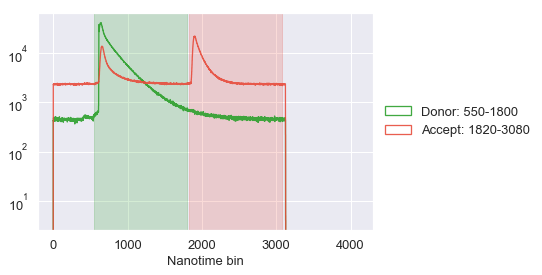

In [12]:
bpl.plot_alternation_hist(d)

Execute the previous 2 cells until you get a satisfying 
selection for the excitation periods. Then run the following 
to apply the parameters:

In [13]:
loader.alex_apply_period(d)

# Total photons (after ALEX selection):    17,823,403
#  D  photons in D+A excitation periods:    8,360,696
#  A  photons in D+A excitation periods:    9,462,707
# D+A photons in  D  excitation period:    11,929,217
# D+A photons in  A  excitation period:     5,894,186



## Burst search and selection
### Calculte the background rate for all photon streams, for each 30s chunk of the measurement

In [234]:
d.calc_bg(fun=bg.exp_fit, time_s=30, tail_min_us='auto', F_bg=1.7)

 - Calculating BG rates ... [DONE]


#### Plot of the mean BG rate for all photon streams ovr the whole acquisition time

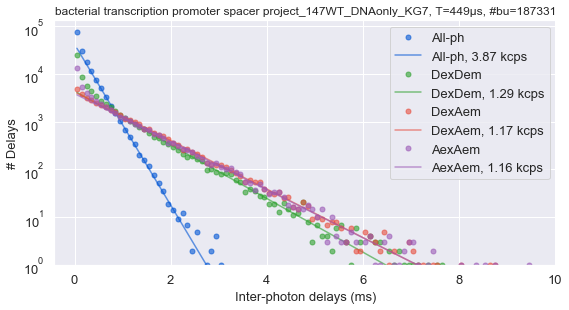

In [235]:
dplot(d, hist_bg, show_fit=True);

### Plot of how the BG rates of all photon streams change with acquistion time (30s bin)

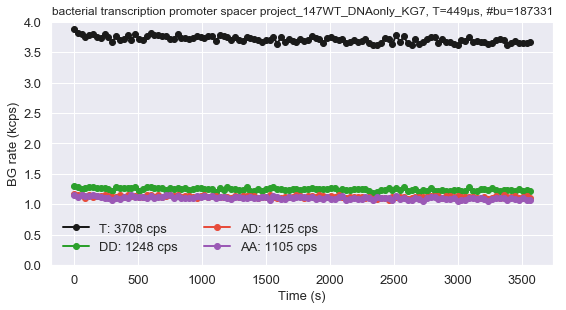

In [236]:
dplot(d, timetrace_bg)

#### A plot of a sample 1s binned data

(-50, 50)

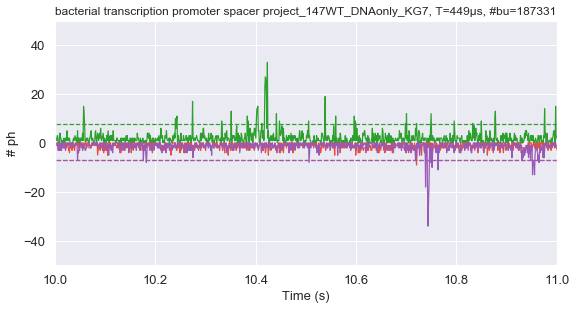

In [237]:
dplot(d, timetrace)
xlim(10, 11)
ylim(-50, 50)

### We start off by using All Channel Burst Search (ACBS), with no corrections

In [238]:
d.burst_search(m=10, F=6)
d.fuse_bursts(ms=0)

 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   - Applying leakage correction.
   - Applying direct excitation correction.
   [DONE Counting D/A]
 - - - - - CHANNEL  1 - - - - 
 --> END Fused 40523 bursts (21.6%, 10 iter)

 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   - Applying leakage correction.
   - Applying direct excitation correction.
   [DONE Counting D/A and FRET]


bacterial transcription promoter spacer project_147WT_DNAonly_KG7 BS_all L10 m10 MR22 G0.669 BGexp-30s Fuse0.0ms bg Lk3.610 dir6.4

In [239]:
d.leakage = 0
d.dir_ex = 0
d.gamma = 1
d.beta = 1
ds_all = d.select_bursts(select_bursts.size, add_naa=True, th1=30)

   - Applying background correction.
   - Applying direct excitation correction.
   - Applying background correction.


C:\Users\eitan\Anaconda3\envs\depi_env\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


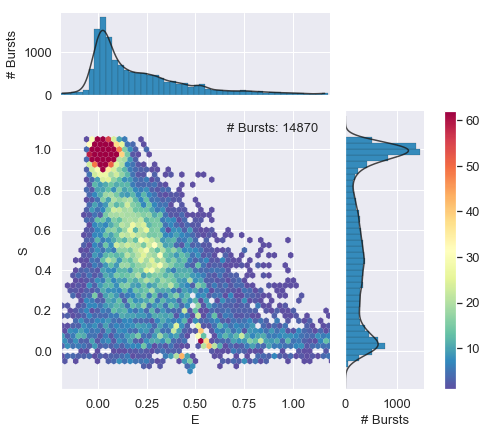

In [240]:
alex_jointplot(ds_all)
#plt.savefig('aSyn39C-ATTO488-39C-ATTO647N_1h_2D_ALEX_all.png', dpi=1200, bbox_inches='tight')

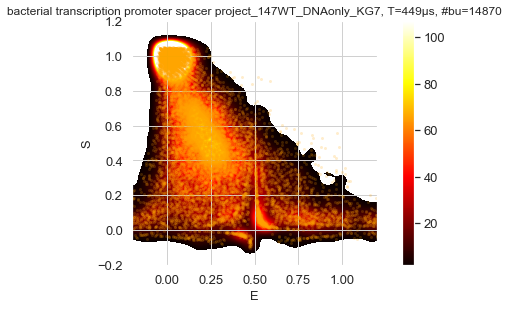

In [241]:
dplot(ds_all, hist2d_alex);

### Then, we select only the donor-only (DO) & acceptor-only (AO) populations

In [242]:
ds_DO = ds_all.select_bursts(select_bursts.S, S1=0.8)
ds_AO = ds_all.select_bursts(select_bursts.S, S2=0.2)

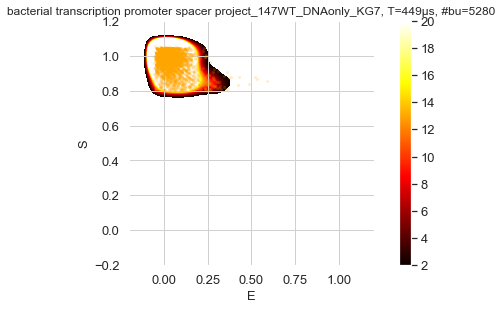

In [243]:
dplot(ds_DO, hist2d_alex);

#### The mean of the DO FRET histogram should be 0. A value >0 is an indication of leakage
We use this value to calculate the Leakage factor - donor fluorescence leakage to the acceptor detection channel

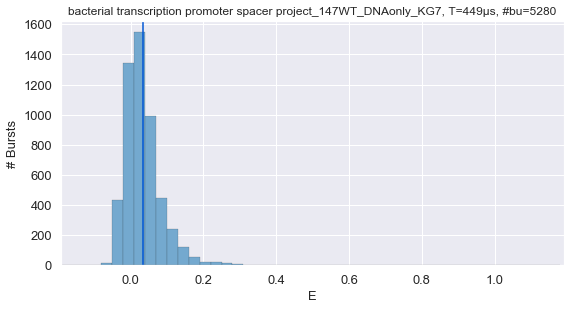

In [244]:
dplot(ds_DO, hist_fret, pdf=False)
plt.axvline(np.mean(ds_DO.E))

In [245]:
Lk = np.mean(ds_DO.E) / (1 - np.mean(ds_DO.E));
Lk

0.03610223532835314

#### The mean of the AO Stoichiometry histogram should be 0. A value >0 is an indication of leakage
We use this value to calculate the Direct acceptor excitation factor - acceptor fluorescence caused by excitation by the laser intended for donor excitation

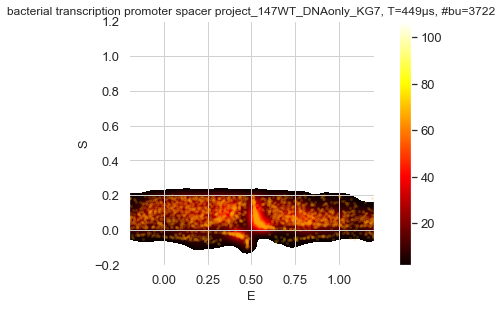

In [246]:
dplot(ds_AO, hist2d_alex);

0.06013319550014877

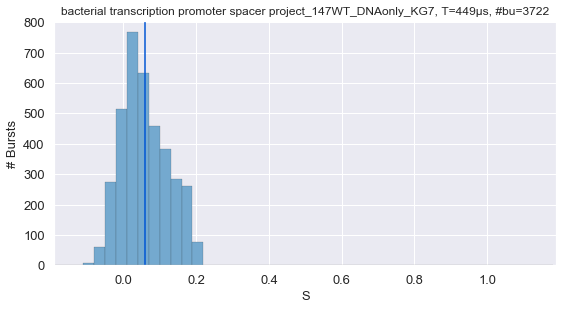

In [247]:
dplot(ds_AO, hist_S, pdf=False)
plt.axvline(np.mean(ds_AO.S))
np.mean(ds_AO.S)

In [248]:
Dir = np.mean(ds_AO.S) / (1 - np.mean(ds_AO.S));
Dir

0.06398055044847399

### After employing Lk & Dir corrections

In [249]:
d.leakage = Lk
d.dir_ex = Dir
d.gamma = 1
d.beta = 1
ds_all = d.select_bursts(select_bursts.size, add_naa=True, th1=30)

   - Applying background correction.
   - Applying leakage correction.
   - Applying background correction.
   - Applying leakage correction.
   - Applying direct excitation correction.


C:\Users\eitan\Anaconda3\envs\depi_env\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


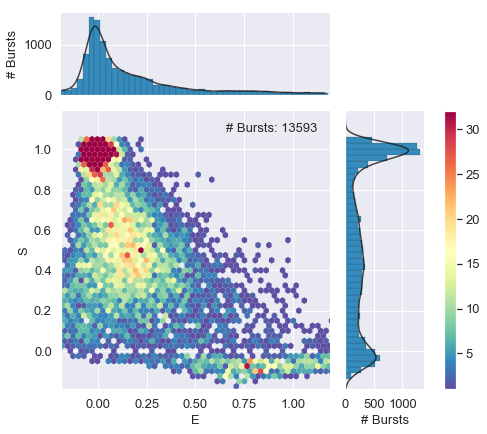

In [250]:
alex_jointplot(ds_all)


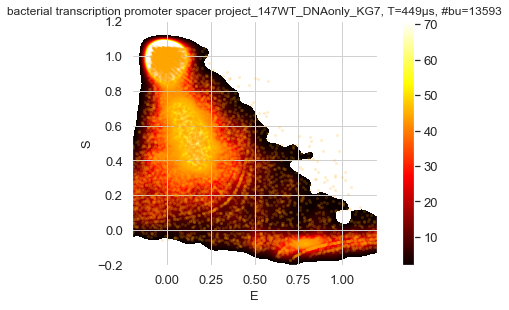

In [251]:
dplot(ds_all, hist2d_alex);

#### Then we check that applying Lk & Dir corrections yielded DO & AO populations with mean E/S value of 0

In [252]:
ds_DO = ds_all.select_bursts(select_bursts.S, S1=0.8)
ds_AO = ds_all.select_bursts(select_bursts.S, S2=0.2)

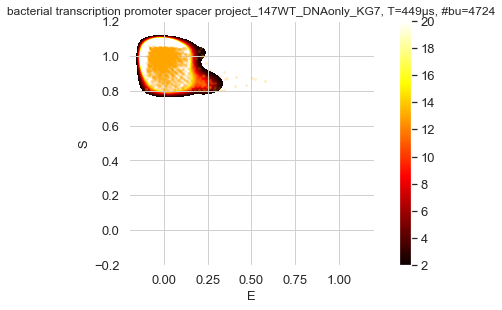

In [253]:
dplot(ds_DO, hist2d_alex);

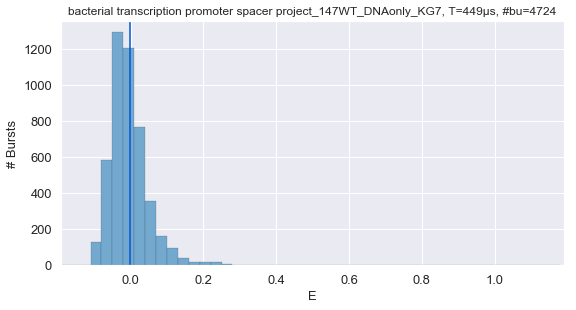

In [254]:
dplot(ds_DO, hist_fret, pdf=False)
plt.axvline(np.mean(ds_DO.E))

In [255]:
np.mean(ds_DO.E)

-0.002923152419657863

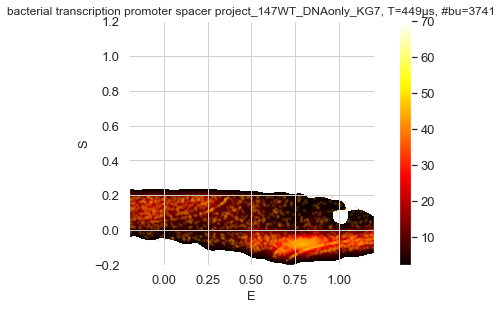

In [256]:
dplot(ds_AO, hist2d_alex);

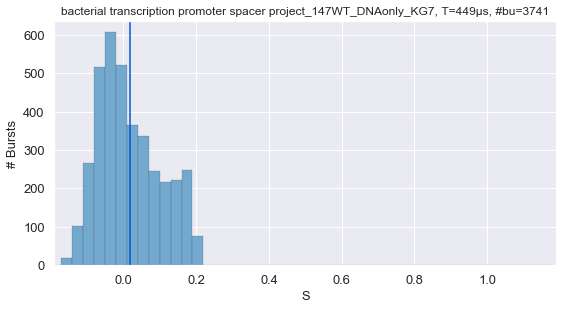

In [257]:
dplot(ds_AO, hist_S, pdf=False)
plt.axvline(np.mean(ds_AO.S))

In [258]:
np.mean(ds_AO.S)

0.017763743860025952

### We move on to calculate the Gamma factor using the donor lifetime information
#### for that we get the FRET population using Dual channel burst search (DCBS)

In [259]:
# DCBS
d_dcbs = bext.burst_search_and_gate(d, F = 6, m = 10)
# Fusion of consecutive bursts with less than m photons separating them
d_dcbs.fuse_bursts(ms=0)
# applying the correction factors acquired so far
d_dcbs.leakage = d.leakage
d_dcbs.dir_ex = d.dir_ex
d_dcbs.gamma = d.gamma
d_dcbs.beta = d.beta

Deep copy executed.
Deep copy executed.
Deep copy executed.
 - Performing burst search (verbose=False) ... - Recomputing background limits for Dex ... [DONE]
 - Recomputing background limits for all ... [DONE]
 - Fixing  burst data to refer to ph_times_m ... [DONE]
[DONE]
 - Calculating burst periods ...[DONE]
 - Performing burst search (verbose=False) ... - Recomputing background limits for AexAem ... [DONE]
 - Recomputing background limits for all ... [DONE]
 - Fixing  burst data to refer to ph_times_m ... [DONE]
[DONE]
 - Calculating burst periods ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   - Applying leakage correction.
   - Applying direct excitation correction.
   [DONE Counting D/A]
 - - - - - CHANNEL  1 - - - - 
 --> END Fused 5165 bursts (28.1%, 9 iter)

 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   - Applying leakage correction.
   - Applyin

In [260]:
# Burst selection

gen_th = 50
# We first select bursts according to a burst size thresholds for ALL photon streams (DD, DA, AA)
# This step helps in haping the S population
ds_FRET = d_dcbs.select_bursts(select_bursts.size, add_naa=True, th1=gen_th)
# Then we select from them bursts according to a burst size threshold for burst streams after donor excitation (DD, DA)
# This step helps in shaping the E population
ds_FRET = ds_FRET.select_bursts(select_bursts.size, add_naa=False, th1=gen_th/2)
# Then we select from them bursts according to a burst size threshold for burst streams after acceptor excitation (AA)
# This step filters out the donor-only species and leaves us only with FRET species
ds_FRET = ds_FRET.select_bursts(select_bursts.naa, th1=gen_th/2)

C:\Users\eitan\Anaconda3\envs\depi_env\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


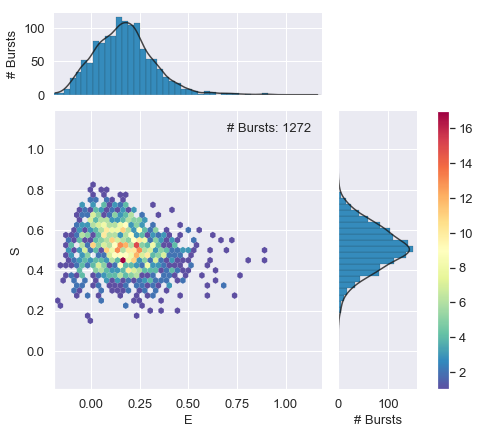

In [261]:
alex_jointplot(ds_FRET)


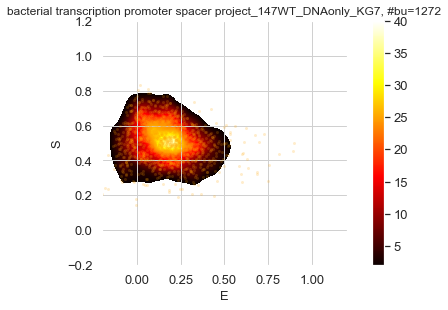

In [262]:
dplot(ds_FRET, hist2d_alex);

#### We keep the mean un-corrected FRET value for further use in the Gamma calculation

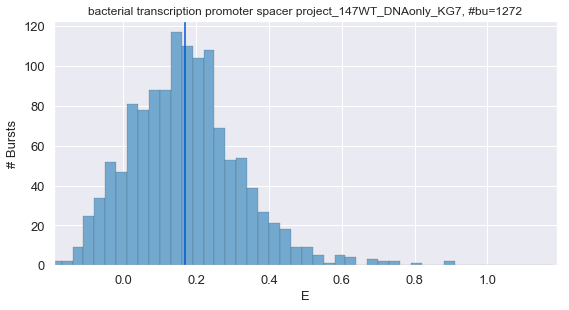

In [263]:
dplot(ds_FRET, hist_fret, pdf=False)
plt.axvline(np.mean(ds_FRET.E))

## Calculating the Gamma factor, per FRET population, using the donor fluorescence nanotimes

In [264]:
# The TCSPC parameters are passed to the burst handler in FRETbursts nalysis of PIE data
d.nanotimes_params

[{'tcspc_unit': 1.5999999936067155e-11,
  'tcspc_num_bins': 4096,
  'tcspc_range': 6.553599973813107e-08}]

In [265]:
def get_nanotimes(d, ph_sel):
    mask = d.ph_in_bursts_mask_ich(ph_sel=ph_sel)
    return d.nanotimes[0][mask]

In [266]:
# This sets the TCSPC parameters to be used in nanotime calculations
tcspc_bin = d.nanotimes_params[0]['tcspc_unit']
tcspc_range = d.nanotimes_params[0]['tcspc_range']
tcspc_num_bins = d.nanotimes_params[0]['tcspc_num_bins']
bins_raw = np.arange(0, tcspc_num_bins)

# Photon selections according to photon streams
ph_sel_d = Ph_sel(Dex='Dem')
ph_sel_a = Ph_sel(Dex='Aem')
ph_sel_aa = Ph_sel(Aex='Aem')

In [267]:
# Getting the nanotimes of different photon stream and different photon selections

# This is for the selected bursts solely of the FRET population(s) - ds_FRET
nanotimes_d_FRET = get_nanotimes(ds_FRET, ph_sel_d)
nanotimes_a_FRET = get_nanotimes(ds_FRET, ph_sel_a)
nanotimes_aa_FRET = get_nanotimes(ds_FRET, ph_sel_aa)

# This is for the selected bursts solely of the DO population - ds_DO
nanotimes_d_DO = get_nanotimes(ds_DO, ph_sel_d)
nanotimes_a_DO = get_nanotimes(ds_DO, ph_sel_a)

hist_params = dict(bins=bins_raw, density=False)
nanot_hist_d_FRET, _ = np.histogram(nanotimes_d_FRET, **hist_params)
nanot_hist_a_FRET, _ = np.histogram(nanotimes_a_FRET, **hist_params)
nanot_hist_aa_FRET, _ = np.histogram(nanotimes_aa_FRET, **hist_params)
nanot_hist_d_DO, _ = np.histogram(nanotimes_d_DO, **hist_params)
nanot_hist_a_DO, _ = np.histogram(nanotimes_a_DO, **hist_params)

Text(0,0.5,'Counts')

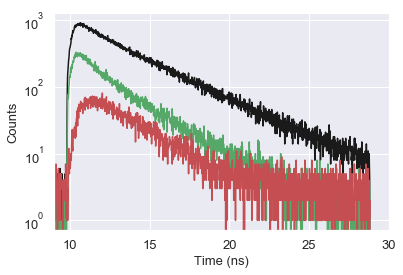

In [268]:
# Plotting the fluorescence decays of different photon selections & photon streams
bins_raw = np.arange(0, tcspc_num_bins)
time_axis_ns = (bins_raw[1:] * tcspc_bin) * 1e9
plt.semilogy(time_axis_ns, nanot_hist_d_DO, 'k')
plt.semilogy(time_axis_ns, nanot_hist_d_FRET, 'g')
plt.semilogy(time_axis_ns, nanot_hist_a_FRET, 'r')
plt.xlim(9,30)
plt.xlabel('Time (ns)')
plt.ylabel('Counts')

Text(0,0.5,'Counts')

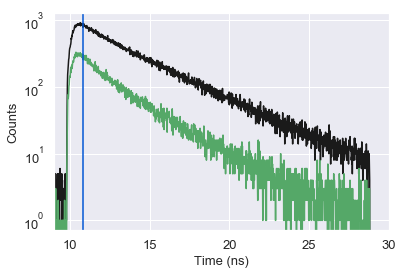

In [269]:
# Plotting the donor fluorescence decays of different photon selections
# In this case I chose to overlay the DO & FRET related donor fluorescence decays
plt.semilogy(time_axis_ns, nanot_hist_d_DO, 'k')
plt.semilogy(time_axis_ns, nanot_hist_d_FRET, 'g')

# For the purpose of calculting mean nanotimes, for a given excitation window (Dex. or Aex. in PIE)
# it is important to choose nanotimes larger than a given lower boundary value. 
# The optimal lower boundary value should be one in which the TCSPC histogram is in its decay part, after the IRF convolution part
# BUT, as low as possible to include as many photon nanotimes as possible in the mean nnotime calculation
plt.axvline(10.8)
plt.xlim(9,30)
plt.xlabel('Time (ns)')
plt.ylabel('Counts')

In [270]:
# Setting the value of the variable that will serve as the lower boundary for the nanotimes of photons belonging to Dex. photon streams
nt_th_Dex = 10.8

Text(0,0.5,'Counts')

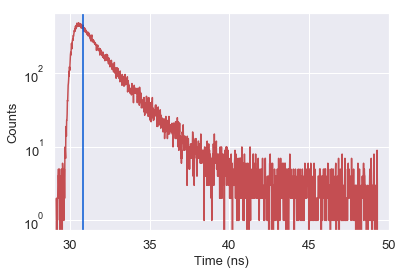

In [271]:
# Plotting the aceptor fluorescence decays of different photon selections
# In this case I chose to diplay the FRET-related acceptor fluorescence decay following acceptor excitation
plt.semilogy(time_axis_ns, nanot_hist_aa_FRET, 'r')
# For the purpose of calculting mean nanotimes, for a given excitation window (Dex. or Aex. in PIE)
# it is important to choose nanotimes larger than a given lower boundary value. 
# The optimal lower boundary value should be one in which the TCSPC histogram is in its decay part, after the IRF convolution part
# BUT, as low as possible to include as many photon nanotimes as possible in the mean nnotime calculation
plt.axvline(30.8)
plt.xlim(29,50)
plt.xlabel('Time (ns)')
plt.ylabel('Counts')

In [272]:
# Setting the value of the variable that will serve as the lower boundary for the nanotimes of photons belonging to Aex. photon streams
nt_th_Aex = 30.8

#### gathering all nanotimes for all photon streams - FRET population

In [273]:
# Choose a handler for the selected bursts you would like to focus on 
ds_tmp = ds_FRET

bursts =ds_tmp.mburst[0]# This grants access to the bursts photons, including to their nanotimes
# Define photon masks for the 3 main photon streams in PIE
DexDem_mask = ds_tmp.get_ph_mask(ph_sel=Ph_sel(Dex='Dem'))   
DexAem_mask = ds_tmp.get_ph_mask(ph_sel=Ph_sel(Dex='Aem'))   
AexAem_mask = ds_tmp.get_ph_mask(ph_sel=Ph_sel(Aex='Aem'))   


# Arrays that will hold the mean nanotime values
nDexDm_corr=[]# for the stream of donor photons after donor excitation
nDexAm_corr=[]# for the stream of acceptor photons after donor excitation
nAexAm_corr=[]# for the stream of acceptor photons after acceptor excitation

# Arrays that will hold the corresponding ratiometric values of E & S
E_corr=[]
S_corr=[]

# Loop over all bursts
for burst in bursts:
    #Set temporary summing variables - used as numerator in the calculations of the burst algebraic average
    tmpDA = 0;
    tmpAA = 0;
    tmpDD = 0;
    
    #Set temporary counter variables - used as denominator in the calculations of the burst algebraic average
    cntDA = 0;
    cntAA = 0;
    cntDD = 0;
    
    # For each burst, loop over its photons
    for i in range(burst.istart, burst.istop):
        # the current photon's nanotime in TCSPC bins units
        cur_nt = ds_tmp.nanotimes[0][i];
        # the current photon's nanotime in nanoseconds
        cur_nt = cur_nt * tcspc_bin * 1e9;
        
        # The case of a Dex.Dem. photon
        if DexDem_mask[i] == 1 and DexAem_mask[i] == 0 and AexAem_mask[i] == 0 and cur_nt > nt_th_Dex:# only consider photon nanotimes larger than a given lower boundary, defining the beginning of the decay part of the TCSPC histogram
            tmpDD += cur_nt;
            cntDD += 1;
        # The case of a Dex.Aem. photon
        elif DexDem_mask[i] == 0 and DexAem_mask[i] == 1 and AexAem_mask[i] == 0 and cur_nt > nt_th_Dex:# only consider photon nanotimes larger than a given lower boundary, defining the beginning of the decay part of the TCSPC histogram
            tmpDA += cur_nt;
            cntDA += 1;
        # The case of a Aex.Aem. photon
        elif DexDem_mask[i] == 0 and DexAem_mask[i] == 0 and AexAem_mask[i] == 1 and cur_nt > nt_th_Aex:# only consider photon nanotimes larger than a given lower boundary, defining the beginning of the decay part of the TCSPC histogram
            tmpAA += cur_nt;
            cntAA += 1;
        
    # The calculation of the mean nanotime for each photon stream in PIE
    # This conditional makes sure there were photons of the given photon stream in the burst. If there were no photons of that photon strem in the given burst, a value of -1 is stored instead.
    # The -1 values should be ignored afterwards in further calculations
    # Anyway, valid mean nanotimes are always larger or equl to 0
    
    # Dex.Dem. calculation
    if cntDD > 0:
        #The calcultion of the algebraic average nanotime 
        cur_mean_nt_DD = tmpDD/cntDD;
        # The mean nanotime has a value relative to the beginning of the decay part of the TCSPC histogram. 
        # Subtraction of this value makes the value of the mean nanotime become relative to 0, as it hould be.
        cur_mean_nt_DD = cur_mean_nt_DD - nt_th_Dex;
    else:
        cur_mean_nt_DD = -1;
    
    # Dex.Aem. calculation
    if cntDA > 0:
        cur_mean_nt_DA = tmpDA/cntDA;
        cur_mean_nt_DA = cur_mean_nt_DA - nt_th_Dex;
    else:
        cur_mean_nt_DA = -1;
    
    # Aex.Aem. calculation
    if cntAA > 0:
        cur_mean_nt_AA = tmpAA/cntAA;
        cur_mean_nt_AA = cur_mean_nt_AA - nt_th_Aex;
    else:
        cur_mean_nt_AA = -1;
    
    
    # Storing the mean nanotime values of the 3 different photons streams in PIE, in their arrays, per each burst
    nDexDm_corr.append(cur_mean_nt_DD)
    nDexAm_corr.append(cur_mean_nt_DA)
    nAexAm_corr.append(cur_mean_nt_AA)

# Looping over all bursts to store the rtiometric E & S values
for j in range(0, len(ds_tmp.E[0])):
    E_corr.append(ds_tmp.E[0][j])
    S_corr.append(ds_tmp.S[0][j])

    

In [274]:
# Sanity check to test that the number of array elements for the mean nanotimes and E & S are identical
assert(len(nDexDm_corr)==len(nDexAm_corr)==len(nAexAm_corr)==len(E_corr)==len(S_corr))

In [275]:
# Store the results of the mean nanotime calculations in local variables that relate to the given burst selection
nDexDm_FRET = nDexDm_corr;
nDexAm_FRET = nDexAm_corr;
nAexAm_FRET = nAexAm_corr;
E_FRET = E_corr;
S_FRET = S_corr;

#### gathering all nanotimes for all photon streams - DO population

In [276]:
ds_tmp = ds_DO

bursts =ds_tmp.mburst[0]
DexDem_mask = ds_tmp.get_ph_mask(ph_sel=Ph_sel(Dex='Dem'))   
DexAem_mask = ds_tmp.get_ph_mask(ph_sel=Ph_sel(Dex='Aem'))   
AexAem_mask = ds_tmp.get_ph_mask(ph_sel=Ph_sel(Aex='Aem'))   



nDexDm_corr=[]
nDexAm_corr=[]
nAexAm_corr=[]
E_corr=[]
S_corr=[]


for burst in bursts:
    tmpDA = 0;
    tmpAA = 0;
    tmpDD = 0;
    
    cntDA = 0;
    cntAA = 0;
    cntDD = 0;
    for i in range(burst.istart, burst.istop):
        cur_nt = ds_tmp.nanotimes[0][i];
        cur_nt = cur_nt * tcspc_bin * 1e9;
        if DexDem_mask[i] == 1 and DexAem_mask[i] == 0 and AexAem_mask[i] == 0 and cur_nt > nt_th_Dex:
            tmpDD += cur_nt;
            cntDD += 1;
        elif DexDem_mask[i] == 0 and DexAem_mask[i] == 1 and AexAem_mask[i] == 0 and cur_nt > nt_th_Dex:
            tmpDA += cur_nt;
            cntDA += 1;
        elif DexDem_mask[i] == 0 and DexAem_mask[i] == 0 and AexAem_mask[i] == 1 and cur_nt > nt_th_Aex:
            tmpAA += cur_nt;
            cntAA += 1;
        
    if cntDD > 0:
        cur_mean_nt_DD = tmpDD/cntDD;
        cur_mean_nt_DD = cur_mean_nt_DD - nt_th_Dex;
    else:
        cur_mean_nt_DD = -1;
    
    if cntDA > 0:
        cur_mean_nt_DA = tmpDA/cntDA;
        cur_mean_nt_DA = cur_mean_nt_DA - nt_th_Dex;
    else:
        cur_mean_nt_DA = -1;
    
    if cntAA > 0:
        cur_mean_nt_AA = tmpAA/cntAA;
        cur_mean_nt_AA = cur_mean_nt_AA - nt_th_Aex;
    else:
        cur_mean_nt_AA = -1;
    
    
    nDexDm_corr.append(cur_mean_nt_DD)
    nDexAm_corr.append(cur_mean_nt_DA)
    nAexAm_corr.append(cur_mean_nt_AA)
    
for j in range(0, len(ds_tmp.E[0])):
    E_corr.append(ds_tmp.E[0][j])
    S_corr.append(ds_tmp.S[0][j])

    

In [277]:
# Sanity check to test that the number of array elements for the mean nanotimes and E & S are identical
assert(len(nDexDm_corr)==len(nDexAm_corr)==len(nAexAm_corr)==len(E_corr)==len(S_corr))

In [278]:
nDexDm_DO = nDexDm_corr;
nDexAm_DO = nDexAm_corr;
nAexAm_DO = nAexAm_corr;
E_DO = E_corr;
S_DO = S_corr;

##### Plots of the donor nanotime histograms - DO & FRET populations

Text(0.5,1,'Mean donor nanotimes - DO vs. FRET')

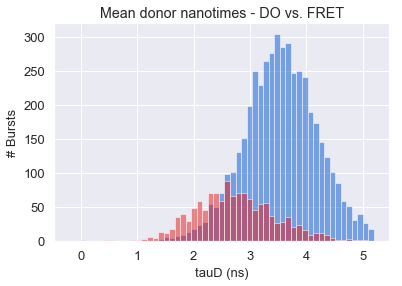

In [279]:
plt.hist(nDexDm_DO, bins=55, range=[-0.2,5.2], alpha=0.5);
plt.hist(nDexDm_FRET, bins=55, range=[-0.2,5.2], alpha=0.5);
plt.xlabel('tauD (ns)')
plt.ylabel('# Bursts')
plt.title('Mean donor nanotimes - DO vs. FRET')

#### calculating the mean donor fluorescence lifetimes and the corrected FRET efficiency
the nanotimes of the photons belonging to the DO & FRET selected bursts are used for calculating the mean of all bursts' mean nanotimes. Then we used them to calculate an etimate for the accurate FRET efficiency.

In [280]:
# The mean value of all mean nanotimes of all bursts of the DO population
mean_DD_DO = np.mean(nDexDm_DO)
# The mean value of all mean nanotimes of all bursts of the FRET population
mean_DD_FRET = np.mean(nDexDm_FRET)
# Using the mean donor lifetimes to estimate the corrected value of the FRET efficiency
mean_FRET = 1 - mean_DD_FRET / mean_DD_DO
# Plotting the values of the mean donor lifetimes of the DO & the FRET population, and the mean FRET fficiency
mean_DD_DO, mean_DD_FRET, mean_FRET

(3.567301628928182, 2.735687368473969, 0.2331213749099419)

In [281]:
# The un-corrected mean FRET fficiency from the FRET histogram
Eapp = np.mean(ds_FRET.E)
Eapp

0.169036078764317

### The Gamma factor value is...
#### This is the procedure of estimating the Gamma factor from the un-corrected FRET efficiency (from FRET histogram) and from the estimate of the accurate mean FRET efficiency, calculated from donor nanotime data

In [282]:
gm = ((1-mean_FRET)/mean_FRET)/((1-Eapp)/Eapp)
gm

0.6691781912911247

### After employing Lk, Dir & Gamma corrections

In [285]:
d.leakage = Lk
d.dir_ex = Dir
d.gamma = gm
# We employ all correction factors, except Beta. We want to check wheather Beta should be larger or smaller than 1
d.beta = 1
ds_all = d.select_bursts(select_bursts.size, add_naa=True, th1=30)

   - Applying background correction.
   - Applying leakage correction.
   - Applying direct excitation correction.
   - Applying background correction.
   - Applying leakage correction.
   - Applying direct excitation correction.


In [286]:
d_dcbs = bext.burst_search_and_gate(d, F = 6, m = 10)
d_dcbs.fuse_bursts(ms=0)
d_dcbs.leakage = d.leakage
d_dcbs.dir_ex = d.dir_ex
d_dcbs.gamma = d.gamma
d_dcbs.beta = d.beta

Deep copy executed.
Deep copy executed.
Deep copy executed.
 - Performing burst search (verbose=False) ... - Recomputing background limits for Dex ... [DONE]
 - Recomputing background limits for all ... [DONE]
 - Fixing  burst data to refer to ph_times_m ... [DONE]
[DONE]
 - Calculating burst periods ...[DONE]
 - Performing burst search (verbose=False) ... - Recomputing background limits for AexAem ... [DONE]
 - Recomputing background limits for all ... [DONE]
 - Fixing  burst data to refer to ph_times_m ... [DONE]
[DONE]
 - Calculating burst periods ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   - Applying leakage correction.
   - Applying direct excitation correction.
   [DONE Counting D/A]
 - - - - - CHANNEL  1 - - - - 
 --> END Fused 5165 bursts (28.1%, 9 iter)

 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   - Applying leakage correction.
   - Applyin

In [287]:
# This time, burst selection has also to take into account burst sizes corrected by the Gamma factor
gen_th = 50
ds_FRET = d_dcbs.select_bursts(select_bursts.size, add_naa=True, th1=gen_th, gamma = d.gamma, beta = d.beta)
ds_FRET = ds_FRET.select_bursts(select_bursts.size, add_naa=False, th1=gen_th/2, gamma = d.gamma, beta = d.beta)
ds_FRET = ds_FRET.select_bursts(select_bursts.naa, th1=gen_th/2, gamma = d.gamma, beta = d.beta)

0.46021587637503364

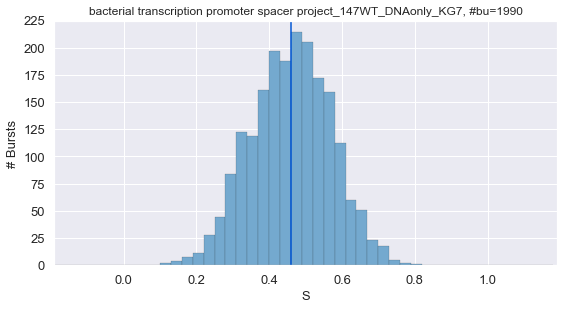

In [288]:
dplot(ds_FRET, hist_S, pdf=False)
plt.axvline(np.mean(ds_FRET.S))
np.mean(ds_FRET.S)

In our case, the mean S value of the FRET population, after applying all corrections (except for Beta) was lower than 0.5 (it was 0.46)
##### If after all corrections the mean S value of the FRET population is <0.5, beta should be >1
##### If after all corrections the mean S value of the FRET population is >0.5, beta should be <1

In [289]:
d.leakage = Lk
d.dir_ex = Dir
d.gamma = gm
# We employ all correction factors, except Beta, 
# and then guess a number for Beta, until the Corrected mean Stoichiometry value reaches a value of 0.5
d.beta = 1.3
# Burst selection including all types of populations
ds_all = d.select_bursts(select_bursts.size, add_naa=True, th1=30)

   - Applying background correction.
   - Applying leakage correction.
   - Applying direct excitation correction.
   - Applying background correction.
   - Applying leakage correction.
   - Applying direct excitation correction.


C:\Users\eitan\Anaconda3\envs\depi_env\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


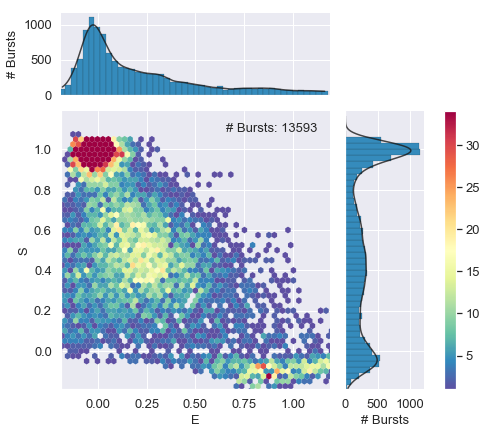

In [290]:
alex_jointplot(ds_all)

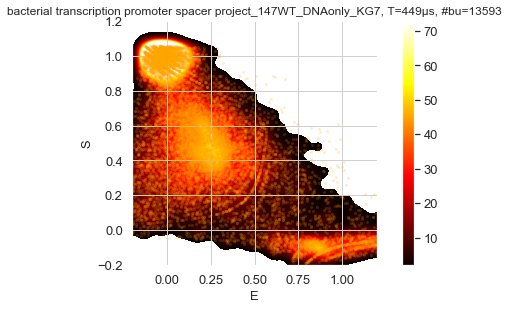

In [291]:
dplot(ds_all, hist2d_alex);

### Testing how well the Lk & Dir corrections worked after applying all corrections

In [292]:
ds_DO = ds_all.select_bursts(select_bursts.S, S1=0.8)
ds_AO = ds_all.select_bursts(select_bursts.S, S2=0.2)

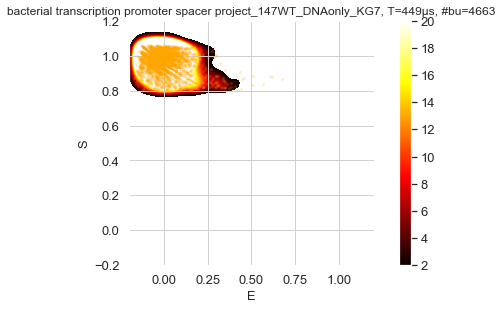

In [293]:
dplot(ds_DO, hist2d_alex);

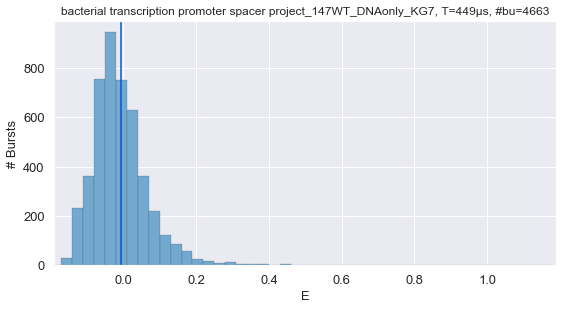

In [294]:
dplot(ds_DO, hist_fret, pdf=False)
plt.axvline(np.mean(ds_DO.E))

In [295]:
np.mean(ds_DO.E)

-0.007339196619375285

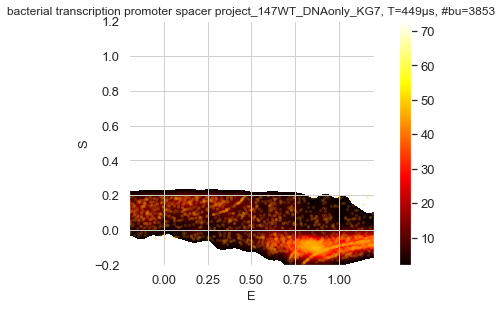

In [296]:
dplot(ds_AO, hist2d_alex);

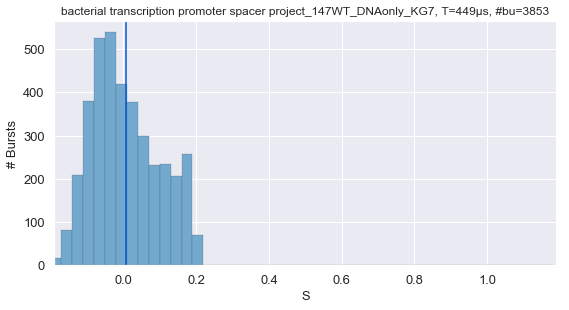

In [297]:
dplot(ds_AO, hist_S, pdf=False)
plt.axvline(np.mean(ds_AO.S))

In [298]:
np.mean(ds_AO.S)

0.007144369710541447

### Testing how well the Beta correction worked after applying all corrections

In [341]:
d_dcbs = bext.burst_search_and_gate(d, F = 6, m = 10)
d_dcbs.fuse_bursts(ms=0)
d_dcbs.leakage = d.leakage
d_dcbs.dir_ex = d.dir_ex
d_dcbs.gamma = d.gamma
d_dcbs.beta = d.beta

Deep copy executed.
Deep copy executed.
Deep copy executed.
 - Performing burst search (verbose=False) ... - Recomputing background limits for Dex ... [DONE]
 - Recomputing background limits for all ... [DONE]
 - Fixing  burst data to refer to ph_times_m ... [DONE]
[DONE]
 - Calculating burst periods ...[DONE]
 - Performing burst search (verbose=False) ... - Recomputing background limits for AexAem ... [DONE]
 - Recomputing background limits for all ... [DONE]
 - Fixing  burst data to refer to ph_times_m ... [DONE]
[DONE]
 - Calculating burst periods ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   - Applying leakage correction.
   - Applying direct excitation correction.
   [DONE Counting D/A]
 - - - - - CHANNEL  1 - - - - 
 --> END Fused 5165 bursts (28.1%, 9 iter)

 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   - Applying leakage correction.
   - Applyin

In [342]:
# This time, burst selection has also to take into account burst sizes corrected by theBeta & Gamma factors
gen_th = 50
ds_FRET = d_dcbs.select_bursts(select_bursts.size, add_naa=True, th1=gen_th, gamma = d.gamma, beta = d.beta)
ds_FRET = ds_FRET.select_bursts(select_bursts.size, add_naa=False, th1=gen_th/2, gamma = d.gamma, beta = d.beta)
ds_FRET = ds_FRET.select_bursts(select_bursts.naa, th1=gen_th/2, gamma = d.gamma, beta = d.beta)

C:\Users\eitan\Anaconda3\envs\depi_env\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


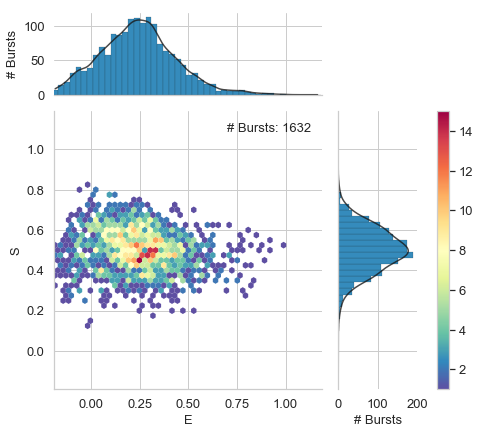

In [343]:
alex_jointplot(ds_FRET)


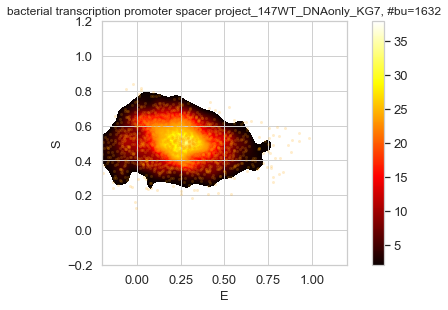

In [344]:
dplot(ds_FRET, hist2d_alex);

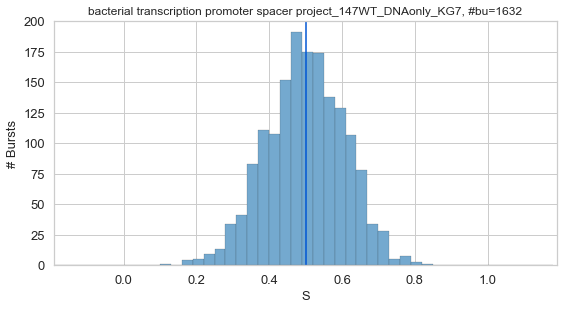

In [345]:
dplot(ds_FRET, hist_S, pdf=False)
plt.axvline(np.mean(ds_FRET.S))

#### At this stage, reaching a FRET population with a mean S value of 0.5, means we found the value of beta and the results are now corrected

In [347]:
np.mean(ds_FRET.S)

0.5008311483943209

#### Here is the fully corrected FRET histogram

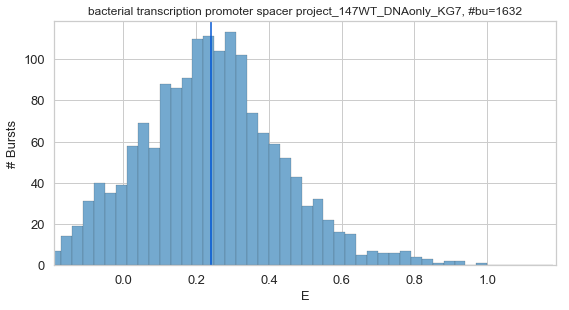

In [348]:
dplot(ds_FRET, hist_fret, pdf=False)
plt.axvline(np.mean(ds_FRET.E))

### MFD calculations on the corrected ratiometric FRET values
#### FRET population

In [349]:
# Choose a handler for the selected bursts you would like to focus on 
ds_tmp = ds_FRET

bursts =ds_tmp.mburst[0]# This grants access to the bursts photons, including to their nanotimes
# Define photon masks for the 3 main photon streams in PIE
DexDem_mask = ds_tmp.get_ph_mask(ph_sel=Ph_sel(Dex='Dem'))   
DexAem_mask = ds_tmp.get_ph_mask(ph_sel=Ph_sel(Dex='Aem'))   
AexAem_mask = ds_tmp.get_ph_mask(ph_sel=Ph_sel(Aex='Aem'))   


# Arrays that will hold the mean nanotime values
nDexDm_corr=[]# for the stream of donor photons after donor excitation
nDexAm_corr=[]# for the stream of acceptor photons after donor excitation
nAexAm_corr=[]# for the stream of acceptor photons after acceptor excitation

# Arrays that will hold the corresponding ratiometric values of E & S
E_corr=[]
S_corr=[]

# Loop over all bursts
for burst in bursts:
    #Set temporary summing variables - used as numerator in the calculations of the burst algebraic average
    tmpDA = 0;
    tmpAA = 0;
    tmpDD = 0;
    
    #Set temporary counter variables - used as denominator in the calculations of the burst algebraic average
    cntDA = 0;
    cntAA = 0;
    cntDD = 0;
    
    # For each burst, loop over its photons
    for i in range(burst.istart, burst.istop):
        # the current photon's nanotime in TCSPC bins units
        cur_nt = ds_tmp.nanotimes[0][i];
        # the current photon's nanotime in nanoseconds
        cur_nt = cur_nt * tcspc_bin * 1e9;
        
        # The case of a Dex.Dem. photon
        if DexDem_mask[i] == 1 and DexAem_mask[i] == 0 and AexAem_mask[i] == 0 and cur_nt > nt_th_Dex:# only consider photon nanotimes larger than a given lower boundary, defining the beginning of the decay part of the TCSPC histogram
            tmpDD += cur_nt;
            cntDD += 1;
        # The case of a Dex.Aem. photon
        elif DexDem_mask[i] == 0 and DexAem_mask[i] == 1 and AexAem_mask[i] == 0 and cur_nt > nt_th_Dex:# only consider photon nanotimes larger than a given lower boundary, defining the beginning of the decay part of the TCSPC histogram
            tmpDA += cur_nt;
            cntDA += 1;
        # The case of a Aex.Aem. photon
        elif DexDem_mask[i] == 0 and DexAem_mask[i] == 0 and AexAem_mask[i] == 1 and cur_nt > nt_th_Aex:# only consider photon nanotimes larger than a given lower boundary, defining the beginning of the decay part of the TCSPC histogram
            tmpAA += cur_nt;
            cntAA += 1;
        
    # The calculation of the mean nanotime for each photon stream in PIE
    # This conditional makes sure there were photons of the given photon stream in the burst. If there were no photons of that photon strem in the given burst, a value of -1 is stored instead.
    # The -1 values should be ignored afterwards in further calculations
    # Anyway, valid mean nanotimes are always larger or equl to 0
    
    # Dex.Dem. calculation
    if cntDD > 0:
        #The calcultion of the algebraic average nanotime 
        cur_mean_nt_DD = tmpDD/cntDD;
        # The mean nanotime has a value relative to the beginning of the decay part of the TCSPC histogram. 
        # Subtraction of this value makes the value of the mean nanotime become relative to 0, as it hould be.
        cur_mean_nt_DD = cur_mean_nt_DD - nt_th_Dex;
    else:
        cur_mean_nt_DD = -1;
    
    # Dex.Aem. calculation
    if cntDA > 0:
        cur_mean_nt_DA = tmpDA/cntDA;
        cur_mean_nt_DA = cur_mean_nt_DA - nt_th_Dex;
    else:
        cur_mean_nt_DA = -1;
    
    # Aex.Aem. calculation
    if cntAA > 0:
        cur_mean_nt_AA = tmpAA/cntAA;
        cur_mean_nt_AA = cur_mean_nt_AA - nt_th_Aex;
    else:
        cur_mean_nt_AA = -1;
    
    
    # Storing the mean nanotime values of the 3 different photons streams in PIE, in their arrays, per each burst
    nDexDm_corr.append(cur_mean_nt_DD)
    nDexAm_corr.append(cur_mean_nt_DA)
    nAexAm_corr.append(cur_mean_nt_AA)

# Looping over all bursts to store the rtiometric E & S values
for j in range(0, len(ds_tmp.E[0])):
    E_corr.append(ds_tmp.E[0][j])
    S_corr.append(ds_tmp.S[0][j])

    

In [350]:
# Sanity check to test that the number of array elements for the mean nanotimes and E & S are identical
assert(len(nDexDm_corr)==len(nDexAm_corr)==len(nAexAm_corr)==len(E_corr)==len(S_corr))

In [351]:
# Store the results of the mean nanotime calculations in local variables that relate to the given burst selection
nDexDm_FRET_corr = nDexDm_corr;
nDexAm_FRET_corr = nDexAm_corr;
nAexAm_FRET_corr = nAexAm_corr;
E_FRET_corr = E_corr;
S_FRET_corr = S_corr;

#### DO population

In [352]:
# Choose a handler for the selected bursts you would like to focus on 
ds_tmp = ds_DO

bursts =ds_tmp.mburst[0]# This grants access to the bursts photons, including to their nanotimes
# Define photon masks for the 3 main photon streams in PIE
DexDem_mask = ds_tmp.get_ph_mask(ph_sel=Ph_sel(Dex='Dem'))   
DexAem_mask = ds_tmp.get_ph_mask(ph_sel=Ph_sel(Dex='Aem'))   
AexAem_mask = ds_tmp.get_ph_mask(ph_sel=Ph_sel(Aex='Aem'))   


# Arrays that will hold the mean nanotime values
nDexDm_corr=[]# for the stream of donor photons after donor excitation
nDexAm_corr=[]# for the stream of acceptor photons after donor excitation
nAexAm_corr=[]# for the stream of acceptor photons after acceptor excitation

# Arrays that will hold the corresponding ratiometric values of E & S
E_corr=[]
S_corr=[]

# Loop over all bursts
for burst in bursts:
    #Set temporary summing variables - used as numerator in the calculations of the burst algebraic average
    tmpDA = 0;
    tmpAA = 0;
    tmpDD = 0;
    
    #Set temporary counter variables - used as denominator in the calculations of the burst algebraic average
    cntDA = 0;
    cntAA = 0;
    cntDD = 0;
    
    # For each burst, loop over its photons
    for i in range(burst.istart, burst.istop):
        # the current photon's nanotime in TCSPC bins units
        cur_nt = ds_tmp.nanotimes[0][i];
        # the current photon's nanotime in nanoseconds
        cur_nt = cur_nt * tcspc_bin * 1e9;
        
        # The case of a Dex.Dem. photon
        if DexDem_mask[i] == 1 and DexAem_mask[i] == 0 and AexAem_mask[i] == 0 and cur_nt > nt_th_Dex:# only consider photon nanotimes larger than a given lower boundary, defining the beginning of the decay part of the TCSPC histogram
            tmpDD += cur_nt;
            cntDD += 1;
        # The case of a Dex.Aem. photon
        elif DexDem_mask[i] == 0 and DexAem_mask[i] == 1 and AexAem_mask[i] == 0 and cur_nt > nt_th_Dex:# only consider photon nanotimes larger than a given lower boundary, defining the beginning of the decay part of the TCSPC histogram
            tmpDA += cur_nt;
            cntDA += 1;
        # The case of a Aex.Aem. photon
        elif DexDem_mask[i] == 0 and DexAem_mask[i] == 0 and AexAem_mask[i] == 1 and cur_nt > nt_th_Aex:# only consider photon nanotimes larger than a given lower boundary, defining the beginning of the decay part of the TCSPC histogram
            tmpAA += cur_nt;
            cntAA += 1;
        
    # The calculation of the mean nanotime for each photon stream in PIE
    # This conditional makes sure there were photons of the given photon stream in the burst. If there were no photons of that photon strem in the given burst, a value of -1 is stored instead.
    # The -1 values should be ignored afterwards in further calculations
    # Anyway, valid mean nanotimes are always larger or equl to 0
    
    # Dex.Dem. calculation
    if cntDD > 0:
        #The calcultion of the algebraic average nanotime 
        cur_mean_nt_DD = tmpDD/cntDD;
        # The mean nanotime has a value relative to the beginning of the decay part of the TCSPC histogram. 
        # Subtraction of this value makes the value of the mean nanotime become relative to 0, as it hould be.
        cur_mean_nt_DD = cur_mean_nt_DD - nt_th_Dex;
    else:
        cur_mean_nt_DD = -1;
    
    # Dex.Aem. calculation
    if cntDA > 0:
        cur_mean_nt_DA = tmpDA/cntDA;
        cur_mean_nt_DA = cur_mean_nt_DA - nt_th_Dex;
    else:
        cur_mean_nt_DA = -1;
    
    # Aex.Aem. calculation
    if cntAA > 0:
        cur_mean_nt_AA = tmpAA/cntAA;
        cur_mean_nt_AA = cur_mean_nt_AA - nt_th_Aex;
    else:
        cur_mean_nt_AA = -1;
    
    
    # Storing the mean nanotime values of the 3 different photons streams in PIE, in their arrays, per each burst
    nDexDm_corr.append(cur_mean_nt_DD)
    nDexAm_corr.append(cur_mean_nt_DA)
    nAexAm_corr.append(cur_mean_nt_AA)

# Looping over all bursts to store the rtiometric E & S values
for j in range(0, len(ds_tmp.E[0])):
    E_corr.append(ds_tmp.E[0][j])
    S_corr.append(ds_tmp.S[0][j])

    

In [353]:
# Sanity check to test that the number of array elements for the mean nanotimes and E & S are identical
assert(len(nDexDm_corr)==len(nDexAm_corr)==len(nAexAm_corr)==len(E_corr)==len(S_corr))

In [354]:
# Store the results of the mean nanotime calculations in local variables that relate to the given burst selection
nDexDm_DO_corr = nDexDm_corr;
nDexAm_DO_corr = nDexAm_corr;
nAexAm_DO_corr = nAexAm_corr;
E_DO_corr = E_corr;
S_DO_corr = S_corr;

#### Some E vs. tau 2D plots, for several nanotimes of different streams

Text(0.5,1,'Ratiometric FRET vs. acceptor mean nanotime (Aex.)\nFRET population')

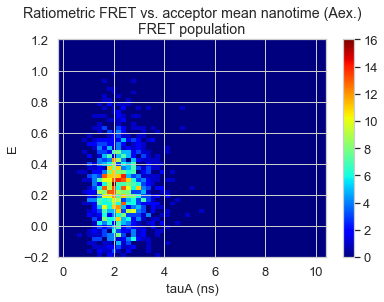

In [355]:
plt.hist2d(nAexAm_FRET_corr, E_FRET_corr, bins=(55,55), range=[[-0.2,10.4],[-0.2,1.2]], cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel('tauA (ns)')
plt.ylabel('E')
plt.title('Ratiometric FRET vs. acceptor mean nanotime (Aex.)\nFRET population')

Text(0.5,1,'Ratiometric FRET vs. acceptor mean nanotime (Dex.)\nFRET population')

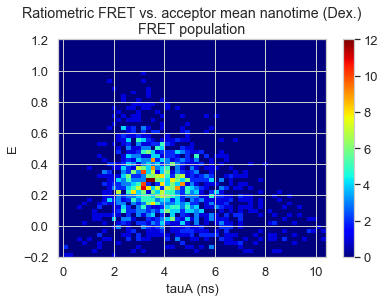

In [356]:
plt.hist2d(nDexAm_FRET_corr, E_FRET_corr, bins=(55,55), range=[[-0.2,10.4],[-0.2,1.2]], cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel('tauA (ns)')
plt.ylabel('E')
plt.title('Ratiometric FRET vs. acceptor mean nanotime (Dex.)\nFRET population')

Text(0.5,1,'Ratiometric FRET vs. Donor mean nanotime\nFRET population')

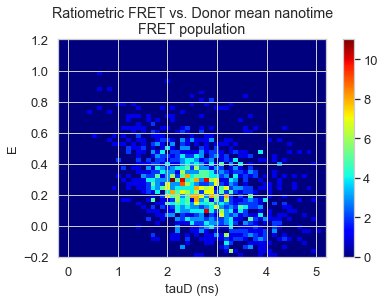

In [357]:
plt.hist2d(nDexDm_FRET_corr, E_FRET_corr, bins=(55,55), range=[[-0.2,5.2],[-0.2,1.2]], cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel('tauD (ns)')
plt.ylabel('E')
plt.title('Ratiometric FRET vs. Donor mean nanotime\nFRET population')

Text(0.5,1,'Ratiometric FRET vs. Donor mean nanotime\nDO population')

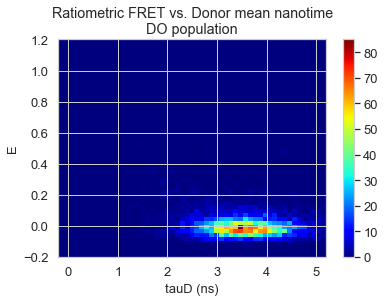

In [358]:
plt.hist2d(nDexDm_DO, E_DO, bins=(55,55), range=[[-0.2,5.2],[-0.2,1.2]], cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel('tauD (ns)')
plt.ylabel('E')
plt.title('Ratiometric FRET vs. Donor mean nanotime\nDO population')

In [359]:
mn_nt_DO = np.mean(nDexDm_DO)
mn_nt_DO

3.567301628928182

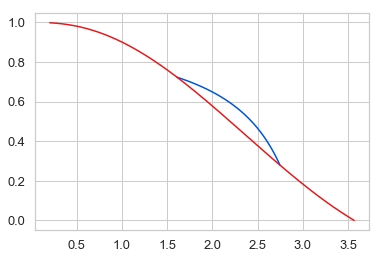

In [360]:
# Definition of normal distribution and Gaussian chain distribution
pdf_norm = lambda x, mean, sigma: np.exp(-(x-mean)**2/(2*sigma**2))/np.sqrt(2*np.pi*sigma**2)
pdf_mix = lambda x, m1, s1, m2, s2, x1: 0.5 * (x1 * pdf_norm(x, m1, s1) + (1-x1) * pdf_norm(x, m2, s1))

rda2fret = lambda rda, r0: 1./(1+(rda/r0)**6.)
rda2tau = lambda rda, tauD0, r0: (1-rda2fret(rda, r0))*tauD0
tau2taux = lambda x, tau: np.dot(x,tau) / np.sum(x)
fret2avfret = lambda x, fret: np.dot(x, fret) / np.sum(x)
tau2tauf = lambda x, tau: np.dot(x,tau**2) / tau2taux(x,tau) / np.sum(x)

tauD0 = mn_nt_DO
r0 = 49
sigma = 10.0
rda = np.linspace(0, 250, 250)
fret_efficiency = rda2fret(rda, r0)
tau = rda2tau(rda, tauD0, r0)

# Calculation of a static FRET line
av_fret = list()
tau_f = list()
scan_range = np.linspace(5, 250, 500)
for m_rda in scan_range:
  x = pdf_norm(rda, m_rda, sigma)
  tau_f.append(tau2tauf(x, tau))
  av_fret.append(fret2avfret(x, fret_efficiency))
static_fret = av_fret
static_tau = tau_f

# Calculation of a dynamic FRET line
m1 = 40
m2 = 60
s1 = s2 = sigma
av_fret = list()
tau_f = list()
scan_range = np.linspace(0, 1, 100)
for x1 in scan_range:
  x = pdf_mix(rda, m1, s1, m2, s2, x1)
  tau_f.append(tau2tauf(x, tau))
  av_fret.append(fret2avfret(x, fret_efficiency))
dynamic_fret = av_fret
dynamic_tau = tau_f

plt.plot(dynamic_tau, dynamic_fret)
plt.plot(static_tau, static_fret)
plt.show()

### Donor nanotime MFD plots
#### FRET population

In [367]:
bns = 50

Text(0.5,1,'Ratiometric FRET vs. Donor mean nanotime\nFRET population')

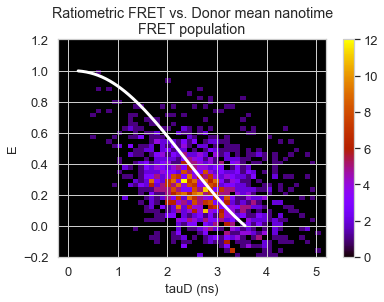

In [368]:
plt.hist2d(nDexDm_FRET_corr, E_FRET_corr, bins=(bns,bns), range=[[-0.2,5.2],[-0.2,1.2]], cmap=plt.cm.gnuplot)
plt.plot(static_tau, static_fret, 'w', linewidth=3)
plt.colorbar()
plt.xlim(-0.2, 5.2)
plt.ylim(-0.2, 1.2)
plt.xlabel('tauD (ns)')
plt.ylabel('E')
plt.title('Ratiometric FRET vs. Donor mean nanotime\nFRET population')

#### DO population

Text(0.5,1,'Ratiometric FRET vs. Donor mean nanotime\nDO population')

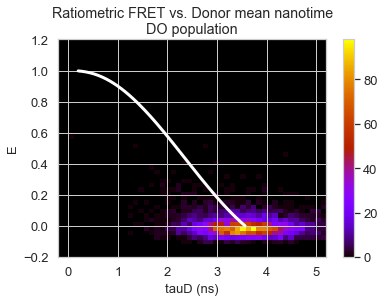

In [369]:
plt.hist2d(nDexDm_DO, E_DO, bins=(bns,bns), range=[[-0.2,5.2],[-0.2,1.2]], cmap=plt.cm.gnuplot)
plt.plot(static_tau, static_fret, 'w', linewidth=3)
plt.colorbar()
plt.xlim(-0.2, 5.2)
plt.ylim(-0.2, 1.2)
plt.xlabel('tauD (ns)')
plt.ylabel('E')
plt.title('Ratiometric FRET vs. Donor mean nanotime\nDO population')

### Some plots of burst statistics
#### Burst size histograms

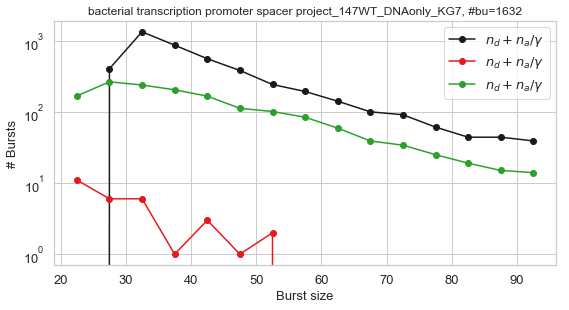

In [370]:
bins=(20, 100, 5)
dplot(ds_DO, hist_size, bins=bins);
dplot(ds_AO, hist_size, bins=bins, ax=plt.gca(), plot_style={'color': 'C1', });
dplot(ds_FRET, hist_size, bins=bins, ax=plt.gca(), plot_style={'color': 'C2', });

#### Burst width histograms

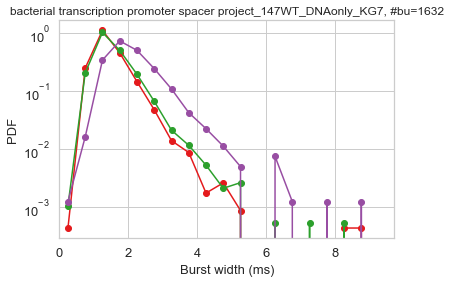

In [371]:
bins=(0, 10, 0.5)
dplot(ds_DO, hist_width, bins=bins, ax=plt.gca(), plot_style={'color': 'C1', });
dplot(ds_AO, hist_width, bins=bins, ax=plt.gca(), plot_style={'color': 'C2', });
dplot(ds_FRET, hist_width, bins=bins, ax=plt.gca(), plot_style={'color': 'C3', });


#### Burst peak photon rate histograms

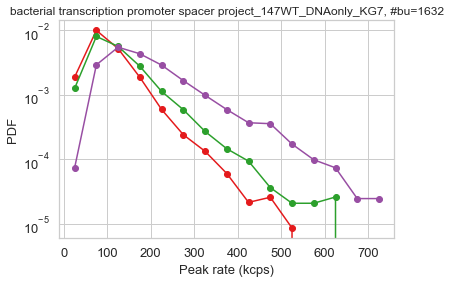

In [372]:
bins=(0, 800, 50)
dplot(ds_DO, hist_burst_phrate, bins=bins, ax=plt.gca(), plot_style={'color': 'C1', });
dplot(ds_AO, hist_burst_phrate, bins=bins, ax=plt.gca(), plot_style={'color': 'C2', });
dplot(ds_FRET, hist_burst_phrate, bins=bins, ax=plt.gca(), plot_style={'color': 'C3', });


# BVA
### BVA analysis is run on photons of bursts following ACBS, with no corrections applied

#### We run BVA analysis to make sure the FRET population we have are static. If they are time averages of faster occurring dynamics, their mean FRET efficiency is irrelevant for the per-population Gamma factor calculation

In [373]:
ds.burst_search(m=10, F=6, ph_sel=Ph_sel(Dex='DAem'), computefret=False)
ds.calc_fret(count_ph=True, corrections=False)
ds.fuse_bursts(ms=0)
ds1 = Sel(ds, select_bursts.naa, th1=25)
ds1 = Sel(ds1, select_bursts.size, th1=25)


bursts =ds1.mburst[0]
ph_d = ds1.get_ph_times(ph_sel=Ph_sel(Dex='DAem'))
AemDex_mask = ds1.get_ph_mask(ph_sel=Ph_sel(Dex='Aem')) 
Dex_mask = ds1.get_ph_mask(ph_sel=Ph_sel(Dex='DAem'))   
AemDex_mask_d = AemDex_mask[Dex_mask]

bursts_d = bursts.recompute_index_reduce(ph_d)

n=5        # Determine the number of photons inside each sub-burst

Std_small=[]
Avg_small=[]
for burst in bursts_d:
    E_small=[]
    startlist = range(burst.istart, burst.istop + 2 - n, n)
    stoplist = [i + n for i in startlist]
    for start, stop in zip(startlist, stoplist): 
        A_D = AemDex_mask_d[start:stop].sum()
        assert stop-start == n
        E = A_D / n
        E_small.append(E)
    Std_small.append(np.std(E_small))
    Avg_small.append(np.average(E_small))


R=20
B_Thr= 60
E_small_num=[]
E_list_num=[]
bn=np.arange(0,1+(2/R),1/R)
Std_small1=[]    
for b1, b2 in zip(bn[:-1], bn[1:]):
    E_small1=[]
    E_list=[]
    for burst in bursts_d:
        A_D = AemDex_mask_d[burst.istart:burst.istop+1].sum()
        E_calc = A_D/burst.counts
        if E_calc >= b1 and E_calc < b2:
            E_list.append(E_calc)           
            startlist = range(burst.istart, burst.istop + 2 - n, n)
            stoplist = [i + n for i in startlist]
            for start, stop in zip(startlist, stoplist): 
                A_D = AemDex_mask_d[start:stop].sum()
                assert stop-start == n
                E = A_D / n
                E_small1.append(E)

# Stds of the bins would be rejected if the numbers of bursts in the bins are smaller than B_Thr 
    if np.array(E_list).shape[0] >= B_Thr:            #
        Std_small1.append(np.std(E_small1))              
    else:
        Std_small1.append(-1)

 - Performing burst search (verbose=False) ... - Recomputing background limits for Dex ... [DONE]
 - Recomputing background limits for all ... [DONE]
 - Fixing  burst data to refer to ph_times_m ... [DONE]
[DONE]
 - Calculating burst periods ...[DONE]
 - - - - - CHANNEL  1 - - - - 
 --> END Fused 26004 bursts (17.1%, 12 iter)

 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   - Applying leakage correction.
   - Applying direct excitation correction.
   [DONE Counting D/A and FRET]
   - Applying background correction.
   - Applying leakage correction.
   - Applying direct excitation correction.


C:\Users\eitan\Anaconda3\envs\depi_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'$\\sigma_{E^*}$')

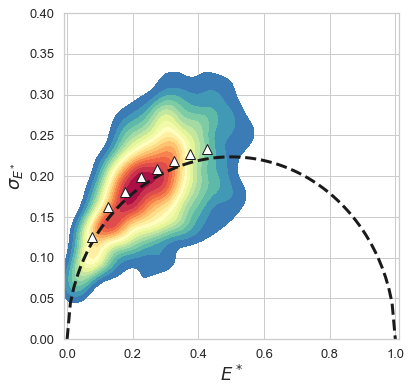

In [374]:
# sns.set_style(style='darkgrid')
x_bin = bn[:-1]+1/(2*R)
plt.figure(figsize=(6,6))
x_T=np.arange(0,1.01,0.01)
y_T=np.sqrt((x_T*(1-x_T))/n)
plt.plot(x_T,y_T, lw=3, color='k', ls='--')
im = sns.kdeplot(np.array(Avg_small), np.array(Std_small), shade=True, cmap='Spectral_r', n_levels=20, shade_lowest=False, gridsize=100)
plt.plot (x_bin ,np.array(Std_small1), marker="^", color='white', mew=1, mec='k', lw=0, ms=10, alpha=1)
plt.xlim(-0.01,1.01)
plt.ylim(0,0.4)
plt.xlabel('$E^*$', fontsize=18)
plt.ylabel(r'$\sigma_{E^*}$', fontsize=18)

#plt.savefig(full_fname , dpi=200, bbox_inches='tight')

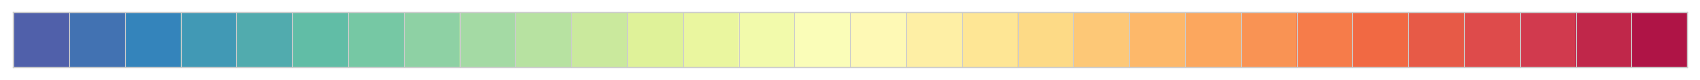

In [375]:
sns.palplot(sns.color_palette('Spectral_r', 30))
BLUE = sns.color_palette('Spectral_r', 30)[0]

C:\Users\eitan\Anaconda3\envs\depi_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'PR')

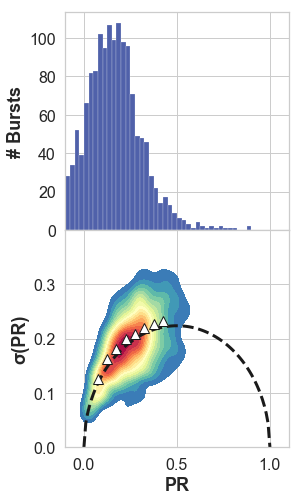

In [376]:
hist_bar_style={'facecolor': BLUE, 'alpha': 1, 'edgecolor': 'white', 'linewidth':0.2}

pnlsRows = 2
pnlsCols = 1
sns.set_style(style='whitegrid')
fig, ax = plt.subplots(pnlsRows, pnlsCols, sharex=True, figsize=(4*pnlsCols, 4*pnlsRows))
plt.subplots_adjust(hspace=0, wspace=0.2)

dplot(ds1, hist_fret, pdf=False, weights = None, ax=ax[0], binwidth=0.025, hist_bar_style=hist_bar_style)


x_T=np.arange(0,1.01,0.01)
y_T=np.sqrt((x_T*(1-x_T))/n)
ax[1].plot(x_T,y_T, lw=3, color='k', ls='--')

im = sns.kdeplot(np.array(Avg_small), np.array(Std_small), shade=True, cmap='Spectral_r', n_levels=20, shade_lowest=False, gridsize=100, ax=ax[1])
ax[1].plot (x_bin ,np.array(Std_small1), marker="^", color='white', mew=1, mec='k', lw=0, ms=10, alpha=1)


#ax[0,0].set_title('(-15)TA-(+2)NTD', fontsize=18, fontname='arial', fontweight='bold')
#ax[0,1].set_title('(-3)TA-(-6)NTD', fontsize=18, fontname='arial', fontweight='bold')
#ax[0,2].set_title('(-8)TA-(-6)NTD', fontsize=18, fontname='arial', fontweight='bold')


#ax[0].set_ylim(0,590)
ax[1].set_ylim(0,0.4)

#ax[0].set_yticks(np.arange(0, 590, 200))
ax[1].set_yticks(np.arange(0, 0.4, 0.1))

for a in ax.ravel():
    a.set_xlabel('')
    a.set_ylabel('')
    a.set_title('')
    a.set_xlim(-0.1,1.1)
    a.tick_params(axis='both', which='major', labelsize=16)
    a.tick_params(axis='both', which='minor', labelsize=14)

ax[0].set_ylabel('# Bursts', fontsize=18, fontname='arial', fontweight='bold')
ax[1].set_ylabel('σ(PR)', fontsize=18, fontname='arial', fontweight='bold')
ax[1].set_xlabel('PR', fontsize=18, fontname='arial', fontweight='bold')



##### The FRET population is static